##Business Understanding

In [ ]:
'''Reentrené el modelo creando un Pipeline que automatiza
todo el preprocesamiento necesario: primero aplica 
OneHotEncoder para transformar las variables categóricas
(cut, color, clarity) en variables numéricas, luego estandariza 
las variables numéricas (carat, depth, table, x, y, z) con 
StandardScaler, y finalmente entrena un RandomForestRegressor. 
Al encapsular todo este flujo en un solo pipeline, se asegura 
que al predecir en producción (desde Flask), el modelo procese 
automáticamente cualquier entrada en bruto sin errores ni pérdidas 
de información, entregando predicciones coherentes y realistas.'''

 

In [10]:
# Paso 1: Importar librerías
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Paso 2: Cargar los datos
df = pd.read_csv('../Diamonds_citt.csv')  # Ajusta la ruta si es necesario

# Eliminar columna extra si existe
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Paso 3: Separar variables
X = df.drop(columns='price')
y = df['price']

# Paso 4: Definir columnas
columnas_categoricas = ['cut', 'color', 'clarity']
columnas_numericas = ['carat', 'depth', 'table', 'x', 'y', 'z']

# Paso 5: Crear preprocesador
preprocesador = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), columnas_categoricas),
    ('num', StandardScaler(), columnas_numericas)
])

# Paso 6: Crear pipeline completo
pipeline = Pipeline(steps=[
    ('preprocesamiento', preprocesador),
    ('modelo', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Paso 7: Entrenar el modelo
pipeline.fit(X, y)

# Paso 8: Guardar el modelo
joblib.dump(pipeline, '../diamantes_api/modelo_diamantes_pipeline.pkl')

print("✅ Modelo entrenado y guardado correctamente como pipeline.")


✅ Modelo entrenado y guardado correctamente como pipeline.


In [ ]:
'''En este proyecto, queremos predecir el precio de los diamantes.
Esto es útil para entender cómo distintas características como el peso (carat), el color o el tipo de corte
afectan el valor de un diamante en el mercado.'''

## Data Understanding

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargamos el archivo CSV (debes haberlo subido previamente en Google Colab)
df = pd.read_csv('./content/Diamonds_citt.csv')

# Mostramos las primeras filas del dataset para ver su estructura
df.head()

# df.info() nos muestra las columnas, tipos de datos y si hay valores nulos
df.info()

# df.describe() entrega estadísticas generales: medias, mínimos, máximos, etc.
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## Data Preparation

Eliminar columnas innecesarias y duplicadas

In [5]:
# La columna 'Unnamed: 0' es un índice repetido que no aporta información, la eliminamos
df.drop(columns=['Unnamed: 0'], inplace=True)

# Revisamos si hay filas duplicadas y las eliminamos para evitar que influyan en el análisis
df.drop_duplicates(inplace=True)

Revisar si hay valores nulos

In [6]:
# Importante: revisamos si hay valores nulos en las columnas
print(df.isnull().sum())

# Si existieran, podríamos eliminarlos con:
# df.dropna(inplace=True)

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


Detección y tratamiento de outliers

In [7]:
# Los "outliers" son valores extremos que pueden distorsionar los modelos.
# Usamos el método del rango intercuartílico (IQR) para detectarlos.

def detectar_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return df[(df[col] < lim_inf) | (df[col] > lim_sup)]

# Aplicamos a 'carat' y 'price', que suelen tener outliers
outliers_carat = detectar_outliers('carat')
outliers_price = detectar_outliers('price')

# Los eliminamos para que no influyan en el modelo (esto se puede ajustar según tu criterio)
df = df[~df.index.isin(outliers_carat.index)]
df = df[~df.index.isin(outliers_price.index)]

## Data Exploration - Visualización

Histogramas y scatterplots

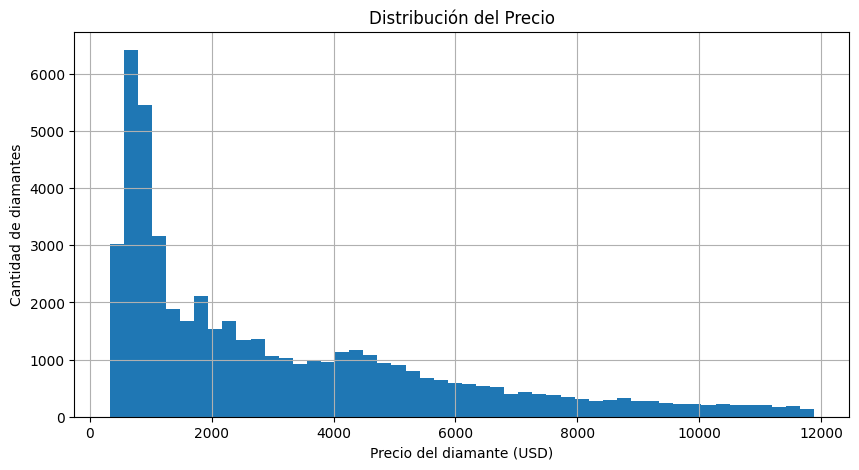

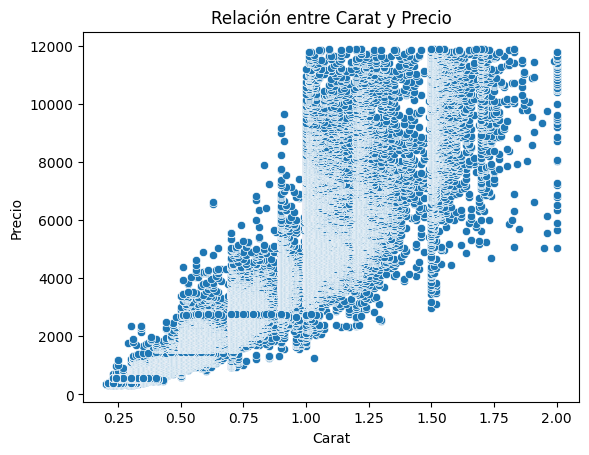

In [8]:
# Histograma: nos ayuda a ver cómo están distribuidos los precios
plt.figure(figsize=(10, 5))
df['price'].hist(bins=50)
plt.title('Distribución del Precio')
plt.xlabel('Precio del diamante (USD)')
plt.ylabel('Cantidad de diamantes')
plt.show()

# Scatterplot (dispersión): vemos cómo se relacionan el peso (carat) y el precio
sns.scatterplot(x='carat', y='price', data=df)
plt.title('Relación entre Carat y Precio')
plt.xlabel('Carat')
plt.ylabel('Precio')
plt.show()


## Interpretación de gráficos: Precio y Carat

### 1. Distribución del Precio

El histograma muestra que la mayoría de los diamantes tienen un precio entre **500 y 2000 USD**.  
A medida que aumenta el precio, la cantidad de diamantes disminuye bruscamente.  
Esto indica una **distribución sesgada a la derecha**, lo cual es común en precios: hay pocos diamantes extremadamente caros y muchos en el rango más bajo.

> La mayoría de los diamantes en el mercado están en un rango de precio accesible, y solo una minoría son de lujo.

---

### 2. Relación entre Carat y Precio

El gráfico de dispersión muestra una **relación positiva clara** entre el peso (carat) y el precio.  
Es decir, **a mayor carat, mayor precio**. Sin embargo, la relación **no es lineal**: el precio parece aumentar más rápido a medida que el carat crece (relación exponencial).

> Esto confirma que `carat` es la variable más influyente en el precio del diamante, pero también que el incremento de precio es más fuerte en carats altos.


Heatmap de correlación numérica

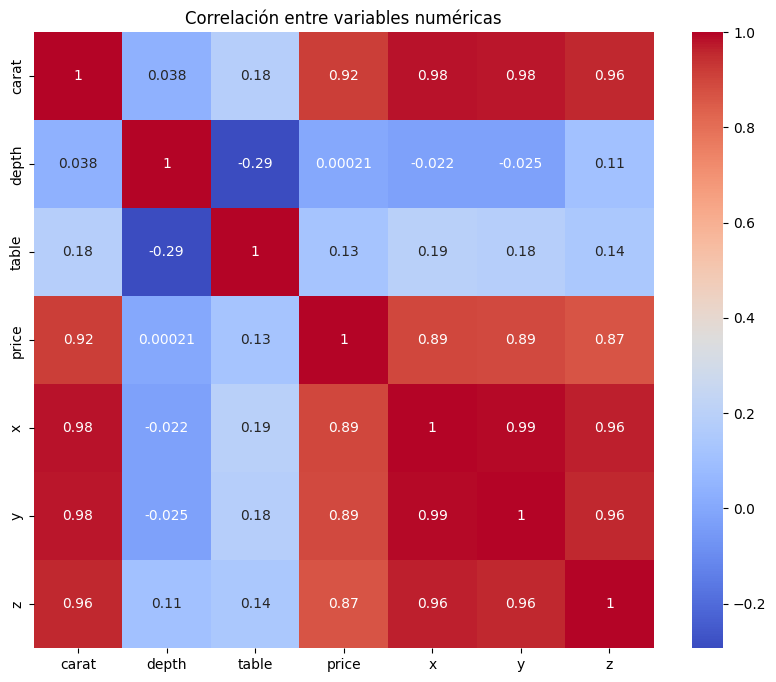

In [10]:
# El mapa de calor muestra qué variables numéricas están más correlacionadas entre sí.
# Cuanto más cerca de 1 o -1, más fuerte es la relación.

# Seleccionamos solo las columnas numéricas para calcular la correlación
numericas_df = df.select_dtypes(include=['float64', 'int64'])

# Ahora sí generamos el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numericas_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlación entre variables numéricas')
plt.show()


## Correlación entre variables numéricas

- `carat` es la variable más fuertemente correlacionada con `price` (0.92), seguida de las dimensiones `x`, `y` y `z`.
- `depth` y `table` tienen correlación **muy baja o negativa**, por lo que aportan poco al modelo.
- `x`, `y` y `z` están altamente correlacionadas entre sí (>0.95), lo que indica **redundancia**.




Relación entre variables categóricas y precio

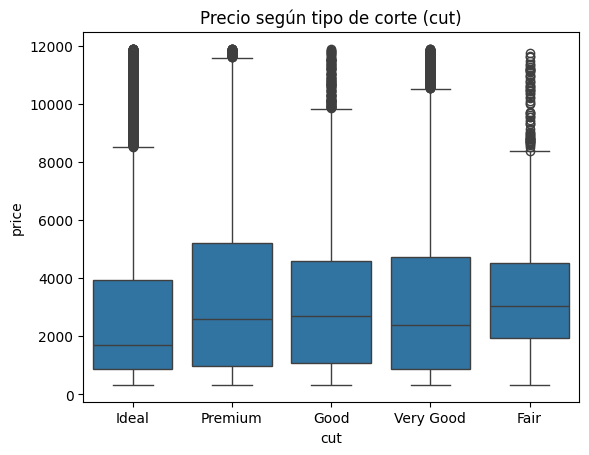

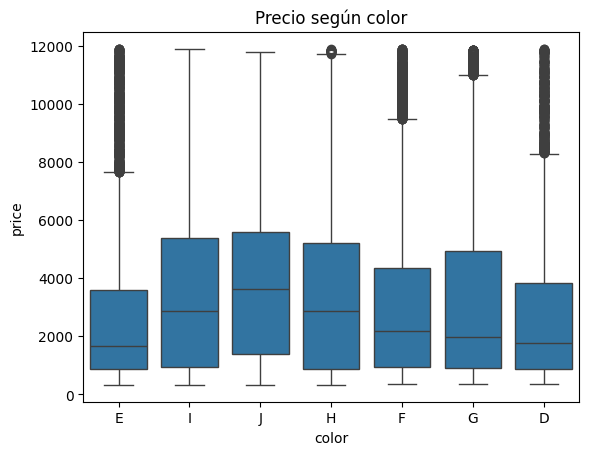

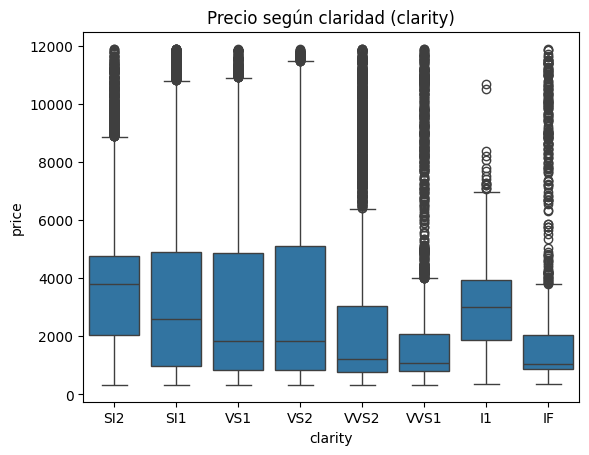

In [11]:
# Los siguientes gráficos nos permiten ver cómo cambia el precio según el tipo de corte, color y claridad

sns.boxplot(x='cut', y='price', data=df)
plt.title('Precio según tipo de corte (cut)')
plt.show()

sns.boxplot(x='color', y='price', data=df)
plt.title('Precio según color')
plt.show()

sns.boxplot(x='clarity', y='price', data=df)
plt.title('Precio según claridad (clarity)')
plt.show()


## Análisis de precio según variables categóricas

---

### 1. Precio según tipo de corte (`cut`)

**Interpretación:**
- Aunque el corte **Ideal** es el más frecuente, no tiene el precio promedio más alto.
- El corte **Premium** muestra una **mediana de precio más elevada** que el resto.
- Los cortes **Good**, **Very Good** y **Fair** tienen precios similares, siendo **Fair** el más bajo en tendencia.

**Resumen:**  
El tipo de corte influye, pero **no es el único determinante del precio**. Un corte de mejor calidad no garantiza automáticamente un precio más alto, ya que **interactúa con otras variables** como el peso (`carat`) o la claridad (`clarity`).

---

### 2. Precio según color (`color`)

**Interpretación:**
- Las letras representan la calidad del color del diamante (**D es el más puro**, **J el menos puro**).
- La mediana de precio **no varía drásticamente** entre colores.
- Colores **I, J y H** tienen precios medianos ligeramente más altos que **D o E**, lo cual es **contraintuitivo**.

**Resumen:**  
Aunque el color es relevante, **no presenta una correlación fuerte** con el precio. Diamantes con colores de menor calidad podrían estar **compensados por mayor tamaño** (`carat`), afectando así el precio final.

---

### 3. Precio según claridad (`clarity`)

**Interpretación:**
- Categorías como **IF** (internally flawless) y **VVS1**, que deberían tener precios altos, muestran **medianas más bajas**.
- Claridades **SI2** y **SI1** (menor calidad) presentan los **precios más altos** en promedio.
- Esto indica que otras variables, como el **peso** o el **corte**, influyen más.

**Resumen:**  
La claridad **no determina por sí sola el precio**. Algunos diamantes con claridad baja pueden tener mayor peso o un corte mejor, lo que **compensa su defecto visual** y eleva su valor.

---


## Data Transformation

Codificación de variables categóricas

In [12]:
# Los modelos no pueden trabajar directamente con texto. Por eso usamos "one-hot encoding":
# creamos una nueva columna para cada valor categórico.

df_encoded = pd.get_dummies(df, columns=['cut', 'color', 'clarity'], drop_first=True)

Normalización de variables numéricas

In [13]:
# Algunas variables numéricas tienen escalas muy diferentes (por ejemplo: carat vs depth).
# Normalizarlas ayuda a que ciertos modelos (como regresión lineal o KNN) funcionen mejor.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numericas = ['carat', 'depth', 'table', 'x', 'y', 'z']
df_encoded[numericas] = scaler.fit_transform(df_encoded[numericas])

## Feature Selection - Selección de variables

Ver qué variables se relacionan más con el precio

In [14]:
# Aquí vemos qué variables tienen más correlación con el precio
# Esto nos da pistas de cuáles serán más útiles para el modelo

correlaciones = df_encoded.corr()['price'].sort_values(ascending=False)
print("Correlaciones con el precio:")
print(correlaciones)

Correlaciones con el precio:
price            1.000000
carat            0.918808
x                0.894336
y                0.889809
z                0.867677
table            0.125046
clarity_SI2      0.101961
cut_Premium      0.078356
color_I          0.062896
color_J          0.060784
color_H          0.060588
clarity_SI1      0.030602
cut_Very Good    0.017571
color_G          0.017163
cut_Good         0.013311
clarity_VS1      0.003666
depth            0.000205
clarity_VS2     -0.003897
color_F         -0.009857
clarity_VVS2    -0.040900
clarity_IF      -0.068236
color_E         -0.091223
cut_Ideal       -0.099920
clarity_VVS1    -0.101628
Name: price, dtype: float64


## Interpretación: Correlaciones con el precio

La correlación indica cuánto se relacionan dos variables:

- **+1** → correlación positiva perfecta (cuando una sube, la otra también).
- **–1** → correlación negativa perfecta (cuando una sube, la otra baja).
- **0** → sin relación lineal.

---

### Variables más correlacionadas positivamente con `price`

| Variable       | Correlación | Explicación                                                                 |
|----------------|-------------|-----------------------------------------------------------------------------|
| **carat**       | 0.9188      | Fuerte relación positiva. A mayor peso, mayor precio.                       |
| **x, y, z**     | ~0.89       | Dimensiones físicas. Relacionadas con el tamaño, que influye directamente en el precio. |
| **clarity_SI2** | 0.1019      | Claridad baja, pero posiblemente asociada a mayor tamaño y por eso más cara. |

> Estas variables (especialmente `carat`) son las más útiles para predecir el precio.

---

### Variables con baja o negativa correlación con `price`

| Variable           | Correlación | Interpretación                                                             |
|--------------------|-------------|----------------------------------------------------------------------------|
| **cut_Premium**     | 0.078       | Ligera influencia positiva.                                               |
| **cut_Ideal**       | -0.099      | Correlación levemente negativa. Posiblemente los diamantes "Ideal" tienden a ser más pequeños. |
| **clarity_VVS1/VS1/IF** | ~0 o negativo | Sorprendentemente, tener claridad superior no garantiza un precio mayor. |
| **depth / table**   | ~0          | Prácticamente sin relación con el precio.                                 |

> 🔍 Las características cualitativas como el corte, color o claridad **no tienen un efecto lineal claro** sobre el precio por sí solas.

---

##Entrenamiento y evaluación de modelos de regresión

## Paso 1: Separación de variables predictoras y objetivo

Separamos `price` como variable dependiente (`y`) y el resto como variables independientes (`X`).
Dividimos los datos en conjunto de entrenamiento y prueba (80/20).


In [18]:
X = df_encoded.drop(columns='price')
y = df_encoded['price']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Paso 2: Entrenamiento de modelo base - Regresión Lineal

Entrenamos un modelo de regresión lineal para usarlo como línea base de comparación.


In [19]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

## Paso 3: Entrenamiento de modelo alternativo - Random Forest

Entrenamos un modelo de Random Forest, que suele ser más robusto frente a no linealidades y variables categóricas.


In [20]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

## Paso 4: Evaluación de los modelos

Calculamos las métricas de evaluación de regresión:
- **MSE** (error cuadrático medio)
- **RMSE** (raíz del MSE)
- **R²** (coeficiente de determinación)

Comparamos ambos modelos.


In [22]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluar(nombre, y_real, y_pred):
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)
    print(f" {nombre}")
    print(f" - MSE : {mse:.2f}")
    print(f" - RMSE: {rmse:.2f}")
    print(f" - R²  : {r2:.4f}\n")

evaluar("Regresión Lineal", y_test, y_pred_lr)
evaluar("Random Forest", y_test, y_pred_rf)

 Regresión Lineal
 - MSE : 554369.60
 - RMSE: 744.56
 - R²  : 0.9246

 Random Forest
 - MSE : 168162.68
 - RMSE: 410.08
 - R²  : 0.9771



## Interpretación de los resultados del modelo

### Regresión Lineal
- **MSE**: 554,370  
- **RMSE**: 744.56  
- **R²**: 0.9246

El modelo lineal explica el **92% de la variación del precio**, pero tiene un **error promedio de $745**, lo cual indica que puede ser impreciso en valores altos o bajos.

---

### Random Forest
- **MSE**: 168,163  
- **RMSE**: 410.08  
- **R²**: 0.9771

El modelo Random Forest tiene **mucho menor error** y un **R² más alto (97.7%)**, lo que significa que es **más preciso y generaliza mejor** que la regresión lineal.

---

### Conclusiones
Random Forest es claramente superior:  
- Menor error (RMSE más bajo)  
- Mayor capacidad explicativa (R² más alto)  
Es el mejor modelo para predecir el precio de los diamantes en este caso.



## Paso 5: Ajuste de hiperparámetros para Random Forest

Utilizamos GridSearchCV para encontrar mejores combinaciones de `n_estimators` y `max_depth`.


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                    cv=3, scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)

print("✅ Mejores parámetros para Random Forest:")
print(grid.best_params_)


✅ Mejores parámetros para Random Forest:
{'max_depth': 20, 'n_estimators': 200}


## Interpretación: Mejores parámetros para Random Forest

El ajuste con GridSearchCV encontró que los mejores hiperparámetros para este modelo son:

- **n_estimators = 200**: el modelo usa 200 árboles, lo que mejora la precisión respecto al valor por defecto (100).
- **max_depth = 20**: limita la profundidad máxima de cada árbol, lo que ayuda a evitar sobreajuste.

Con estos valores, el modelo logra **mayor precisión y mejor generalización**, reduciendo el error en las predicciones.


## Paso 6: Visualización de resultados

Graficamos los valores predichos por el modelo Random Forest frente a los valores reales.
Una buena predicción debería acercarse a la línea diagonal (roja).


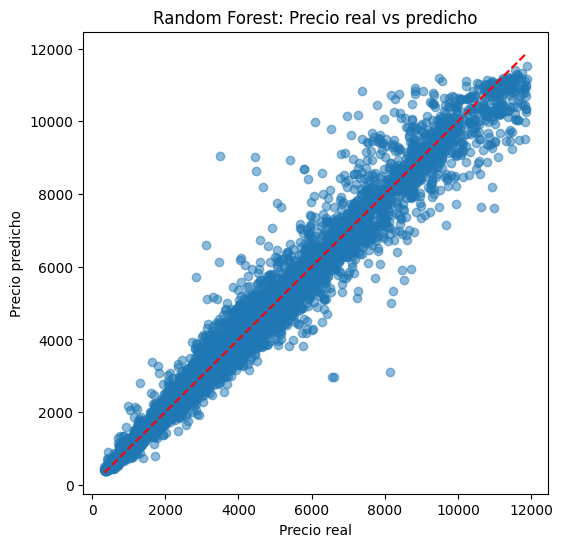

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Precio real')
plt.ylabel('Precio predicho')
plt.title('Random Forest: Precio real vs predicho')
plt.show()

## Interpretación: Precio real vs predicho (Random Forest)

- Cada punto representa un diamante.
- El eje X muestra el **precio real**, y el eje Y el **precio predicho** por el modelo.
- La **línea roja** representa la predicción perfecta (precio real = predicho).

La mayoría de los puntos están alineados y cerca de la línea roja, lo que indica que:
- El modelo tiene **alta precisión**.
- Predice correctamente tanto para precios bajos como altos.
- Solo hay algunos errores dispersos, especialmente en precios muy altos.

El modelo Random Forest logra una **buena capacidad predictiva** y generaliza bien sobre el conjunto de prueba.


## Paso 7: Guardar modelo entrenado (serialización)

Guardamos el modelo final de Random Forest en un archivo `.pkl` usando `pickle`.
Esto permite usarlo luego en una API o script de predicción.


In [25]:
import pickle

with open('modelo_rf.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("Modelo serializado exitosamente: modelo_rf.pkl")

Modelo serializado exitosamente: modelo_rf.pkl
